In [1]:
# Using Python 3.12.1 (local env: HeatNSalt)

## During quality control of the data a few mistakes in the metadata were found, which will be taken care of in this script:
## The column 'Type' has a few mistakes, some specimens were not correctly identified by DNA.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


EPT_14_df = pd.read_csv('outputs/EPT-14-DL.csv')
changes_df = pd.read_excel('raw/EPT-14-change-map.xlsx')
delete_list = changes_df[changes_df['Columns to change'] == 'Delete']['Specimen ID'].to_list()
delete_list.extend(EPT_14_df[EPT_14_df['Specimen Weight']<=0]['Specimen ID'].unique().tolist())
changes_todo = changes_df[changes_df['Columns to change'] != 'Delete']
EPT_14_clean_df = EPT_14_df[~EPT_14_df['Specimen ID'].isin(delete_list)] # remove specimens to delete

for index, row in changes_todo.iterrows():
    if type(row['New values']) != float:
        EPT_14_clean_df.loc[EPT_14_clean_df['Specimen ID'] == row['Specimen ID'], row['Columns to change'].split(', ')] = row['New values'].split(', ')
    else:
        EPT_14_clean_df.loc[EPT_14_clean_df['Specimen ID'] == row['Specimen ID'], row['Columns to change']] = row['New values']

EPT_14_clean_df.loc[:, 'Specimen Weight'] = (EPT_14_clean_df['Tube Weight with dried Specimen'] - EPT_14_clean_df['Empty Tube Weight'])

EPT_14_clean_df.insert(27, 'Log_weights', np.log(EPT_14_clean_df['Specimen Weight']))
EPT_14_clean_df.insert(28, 'Log+1_weights', np.log(EPT_14_clean_df['Specimen Weight']+1))

EPT_14_clean_df.to_csv('outputs/EPT-14-DL-final.csv', index=False)


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
print(f'EPT_DL_Order dataset:')
print(f'Number of classes: {EPT_14_clean_df['Order_DNA'].nunique()}')
pd.DataFrame(EPT_14_clean_df.groupby('Order_DNA')['Specimen ID'].nunique().sort_values(ascending=False))

EPT_DL_Order dataset:
Number of classes: 3


,Specimen ID
Order_DNA,
Trichoptera,569
Ephemeroptera,155
Plecoptera,19


In [3]:
print(f'EPT_DL_Family dataset:')
print(f'Number of classes: {EPT_14_clean_df['Family_DNA'].nunique()}')
pd.DataFrame(EPT_14_clean_df.groupby('Family_DNA')['Specimen ID'].nunique().sort_values(ascending=False))

EPT_DL_Family dataset:
Number of classes: 7


,Specimen ID
Family_DNA,
Limnephilidae,405
Goeridae,119
Ephemeridae,78
Baetidae,56
Leptoceridae,45
Caenidae,21
Nemouridae,19


In [4]:
print(f'EPT_DL_Genus dataset:')
print(f'Number of classes: {EPT_14_clean_df['Genus_DNA'].nunique()}')
print(f'Number of specimen that will be used for deep learning: {EPT_14_clean_df['Specimen ID'].nunique()}')
print(f'Number of species (/classes): {EPT_14_clean_df['Species_DNA'].nunique()}')
print(f'Corresponding number of images: {EPT_14_clean_df['Specimen ID'].count()}')
pd.DataFrame(EPT_14_clean_df.groupby('Genus_DNA')['Specimen ID'].nunique().sort_values(ascending=False))

EPT_DL_Genus dataset:
Number of classes: 13
Number of specimen that will be used for deep learning: 743
Number of species (/classes): 14
Corresponding number of images: 146439


,Specimen ID
Genus_DNA,
Limnephilus,231
Goera,119
Potamophylax,91
Ephemera,78
Baetis,56
Chaetopteryx,45
Athripsodes,33
Caenis,21
Halesus,20


In [5]:
EPT_14_clean_df_short = EPT_14_clean_df.drop_duplicates(subset=['Specimen ID'], keep='first')
EPT_14_clean_df_short = EPT_14_clean_df_short.drop(EPT_14_clean_df_short.columns[1:23], axis=1)
EPT_14_clean_df_short = EPT_14_clean_df_short.drop(EPT_14_clean_df_short.columns[2:4], axis=1)
EPT_14_clean_df_short.to_excel('outputs/EPT-14-short-final.xlsx', index=False)


df_IMG_counts = EPT_14_clean_df
df_IMG_counts = EPT_14_clean_df.groupby('Specimen ID').size().reset_index(name='Image Count')
EPT_14_clean_df_short = EPT_14_clean_df_short.join(df_IMG_counts.set_index('Specimen ID'), on='Specimen ID')

# visualize data distribution:
dddf = EPT_14_clean_df_short[['Order_DNA', 'Species_DNA']]
dddf = dddf.groupby(['Order_DNA', 'Species_DNA']).size().reset_index(name='count')
EPT = dddf.groupby('Order_DNA')['count'].apply(list).to_numpy()
pd.DataFrame(dddf)

,Order_DNA,Species_DNA,count
0,Ephemeroptera,Baetis rhodani,47
1,Ephemeroptera,Baetis vernus,9
2,Ephemeroptera,Caenis horaria,21
3,Ephemeroptera,Ephemera danica,78
4,Plecoptera,Amphinemura standfussi,10
5,Plecoptera,Nemoura cinerea,9
6,Trichoptera,Anabolia nervosa,18
7,Trichoptera,Athripsodes cinereus,33
8,Trichoptera,Chaetopteryx villosa,45
9,Trichoptera,Goera pilosa,119


In [6]:
E_col = ['#F4B63F', '#EF8733', '#EC5A29', '#EA3A24']
P_col = ['#377EBA', '#2A64C5']
T_col = ['#BBD875', '#A4CB73', '#8EBD70', '#78B16E', '#64A46C', '#52976A', '#428A69', '#398068']

inner_colors = []
inner_colors.extend(E_col)
inner_colors.extend(P_col)
inner_colors.extend(T_col)

outer_colors = ['#F19E38', '#4397B0', '#A4CB73']

# # experimental alternative color map:
# E_col = ['#387FCC', '#53B5D6', '#8BE2E6', '#CFFCF8']
# P_col = ['#39612D', '#CCDB71']
# T_col = ['#A7646E', '#D7654C', '#E37352', '#EB8C37', '#F0AF44', '#F5E687', '#F3CF82', '#FCF9C9']

# inner_colors = []
# inner_colors.extend(E_col)
# inner_colors.extend(P_col)
# inner_colors.extend(T_col)

# outer_colors = ['#8BE2E6', '#2E5627', '#F0AF44']

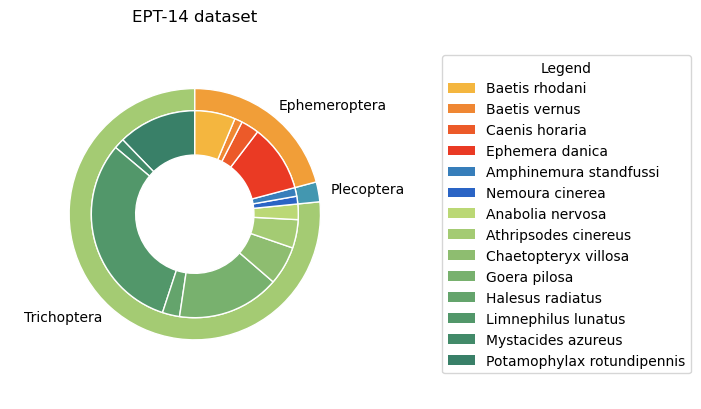

In [7]:
from matplotlib.patches import Patch

fig, ax = plt.subplots()

outer_labels = dddf['Order_DNA'].unique().tolist()
inner_labels = dddf['Species_DNA'].unique().tolist()
size = 0.3

# Outer pie: Three slices (counting EPT)
ax.pie([np.sum(v) for v in EPT][::-1], radius=0.85, labels=outer_labels[::-1], colors=outer_colors[::-1],
       wedgeprops=dict(width=0.15, edgecolor='w'),  startangle=90)

# Inner pie: one slice per Species_DNA
ax.pie([item for sublist in EPT for item in sublist][::-1], radius=1-size, colors=inner_colors[::-1],
       wedgeprops=dict(width=0.3, edgecolor='w'), startangle=90) # to include percentages add: autopct="%1.1f%%", pctdistance=0.8

inner_legend = [Patch(facecolor=inner_colors[i], label=inner_labels[i]) for i in range(len(inner_labels))]
ax.legend(handles=inner_legend, title="Legend", loc="center left", bbox_to_anchor=(1.15, 0, 0.5, 1))
ax.set(aspect='equal', title='EPT-14 dataset')

plt.savefig('outputs/figures/EPT-14 dataset sizes.svg', bbox_inches='tight')
plt.show()

In [8]:
print(f'Sum of reads of all EPT-14 specimen: {EPT_14_clean_df.groupby('Specimen ID').first().groupby('Species_DNA')['read count_DNA'].sum().sum()}')

Sum of reads of all EPT-14 specimen: 170111816.0


In [9]:
pd.DataFrame(EPT_14_clean_df.groupby('Specimen ID').first().groupby('Species_DNA')['read count_DNA'].sum())

,read count_DNA
Species_DNA,
Amphinemura standfussi,2322389.0
Anabolia nervosa,4922305.0
Athripsodes cinereus,7507532.0
Baetis rhodani,13367652.0
Baetis vernus,2109765.0
Caenis horaria,4815871.0
Chaetopteryx villosa,7661887.0
Ephemera danica,15248136.0
Goera pilosa,29443201.0


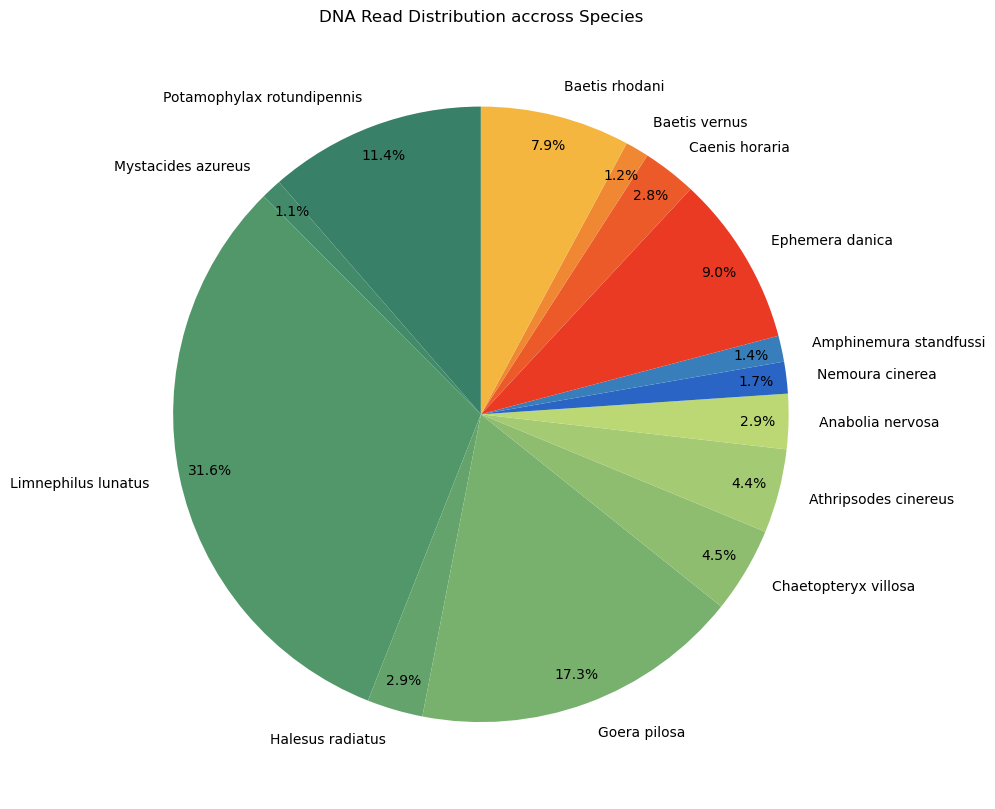

In [10]:
import matplotlib.pyplot as plt

EPT_order = ['Baetis rhodani', 'Baetis vernus', 'Caenis horaria', 'Ephemera danica',
             'Amphinemura standfussi', 'Nemoura cinerea',
             'Anabolia nervosa', 'Athripsodes cinereus', 'Chaetopteryx villosa', 'Goera pilosa', 'Halesus radiatus', 'Limnephilus lunatus', 'Mystacides azureus', 'Potamophylax rotundipennis']


df_DNA = pd.DataFrame(EPT_14_clean_df.groupby('Specimen ID').first().groupby('Species_DNA')['read count_DNA'].sum())
df_DNA = df_DNA.reindex(EPT_order)


E_col = ['#F4B63F', '#EF8733', '#EC5A29', '#EA3A24']
P_col = ['#377EBA', '#2A64C5']
T_col = ['#BBD875', '#A4CB73', '#8EBD70', '#78B16E', '#64A46C', '#52976A', '#428A69', '#398068']

inner_colors = []
inner_colors.extend(E_col)
inner_colors.extend(P_col)
inner_colors.extend(T_col)

plt.figure(figsize=(10, 10))
plt.pie(
    df_DNA['read count_DNA'][::-1],
    labels=df_DNA.index[::-1],
    colors=inner_colors[::-1],
    autopct="%1.1f%%",
    pctdistance=0.9,
    startangle=90
)
plt.title('DNA Read Distribution accross Species')
plt.tight_layout()
plt.show()

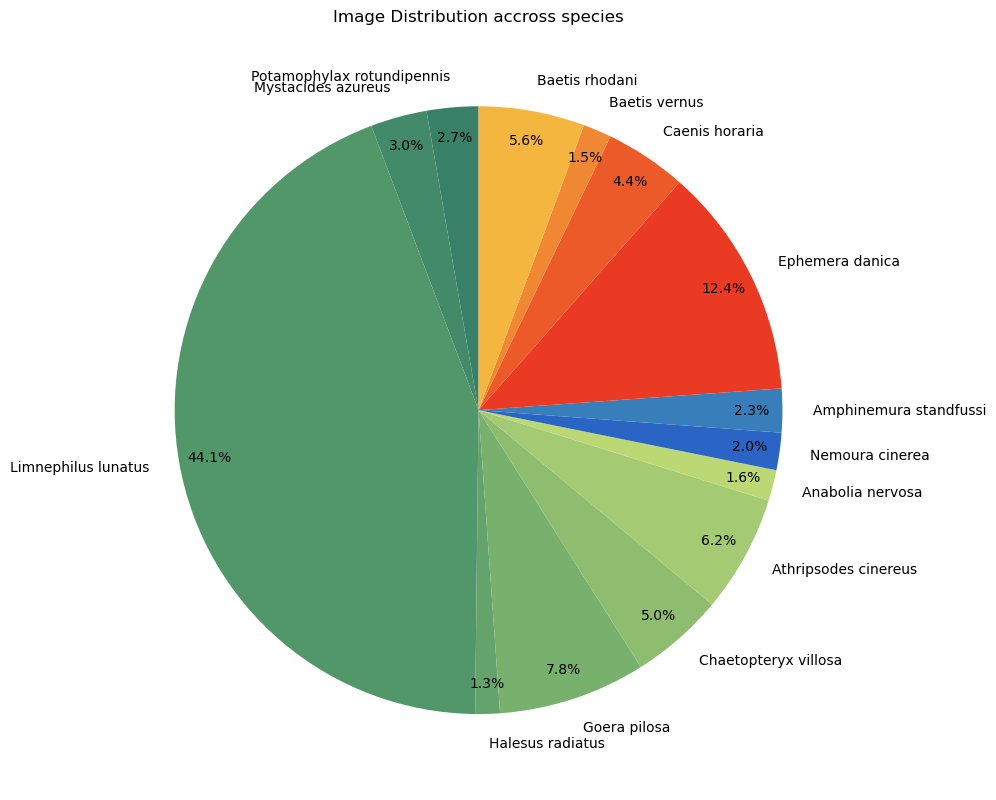

In [11]:
import matplotlib.pyplot as plt

EPT_order = ['Baetis rhodani', 'Baetis vernus', 'Caenis horaria', 'Ephemera danica',
             'Amphinemura standfussi', 'Nemoura cinerea',
             'Anabolia nervosa', 'Athripsodes cinereus', 'Chaetopteryx villosa', 'Goera pilosa', 'Halesus radiatus', 'Limnephilus lunatus', 'Mystacides azureus', 'Potamophylax rotundipennis']


df_IMG = pd.DataFrame(EPT_14_clean_df.groupby('Species_DNA').count())
df_IMG = df_IMG.reindex(EPT_order)


E_col = ['#F4B63F', '#EF8733', '#EC5A29', '#EA3A24']
P_col = ['#377EBA', '#2A64C5']
T_col = ['#BBD875', '#A4CB73', '#8EBD70', '#78B16E', '#64A46C', '#52976A', '#428A69', '#398068']

inner_colors = []
inner_colors.extend(E_col)
inner_colors.extend(P_col)
inner_colors.extend(T_col)

plt.figure(figsize=(10, 10))
plt.pie(
    df_IMG['read count_DNA'][::-1],
    labels=df_IMG.index[::-1],
    colors=inner_colors[::-1],
    autopct="%1.1f%%",
    pctdistance=0.9,
    startangle=90
)
plt.title('Image Distribution accross species')
plt.tight_layout()
plt.show()

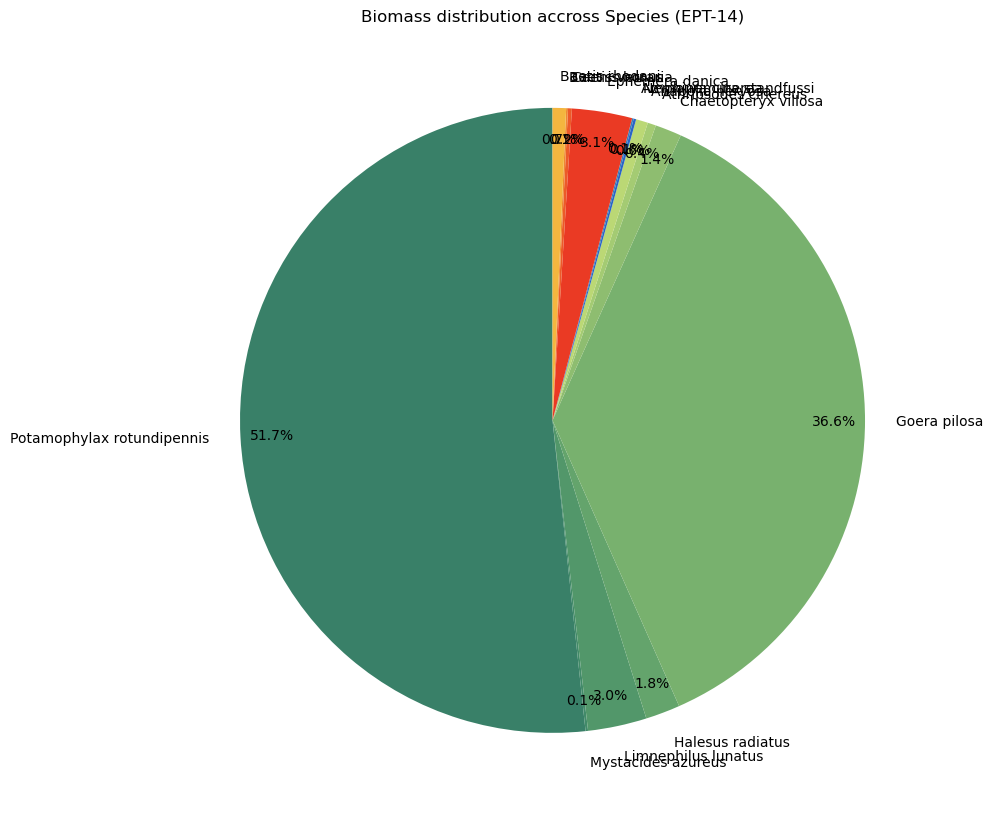

In [12]:
import matplotlib.pyplot as plt

EPT_order = ['Baetis rhodani', 'Baetis vernus', 'Caenis horaria', 'Ephemera danica',
             'Amphinemura standfussi', 'Nemoura cinerea',
             'Anabolia nervosa', 'Athripsodes cinereus', 'Chaetopteryx villosa', 'Goera pilosa', 'Halesus radiatus', 'Limnephilus lunatus', 'Mystacides azureus', 'Potamophylax rotundipennis']


df = pd.DataFrame(EPT_14_clean_df.groupby('Specimen ID').first().groupby('Species_DNA')['Specimen Weight'].sum())
df = df.reindex(EPT_order)


E_col = ['#F4B63F', '#EF8733', '#EC5A29', '#EA3A24']
P_col = ['#377EBA', '#2A64C5']
T_col = ['#BBD875', '#A4CB73', '#8EBD70', '#78B16E', '#64A46C', '#52976A', '#428A69', '#398068']

inner_colors = []
inner_colors.extend(E_col)
inner_colors.extend(P_col)
inner_colors.extend(T_col)

plt.figure(figsize=(10, 10))
plt.pie(
    df['Specimen Weight'][::-1],
    labels=df.index[::-1],
    colors=inner_colors[::-1],
    autopct="%1.1f%%",
    pctdistance=0.9,
    startangle=90
)
plt.title('Biomass distribution accross Species (EPT-14)')
plt.tight_layout()
plt.show()

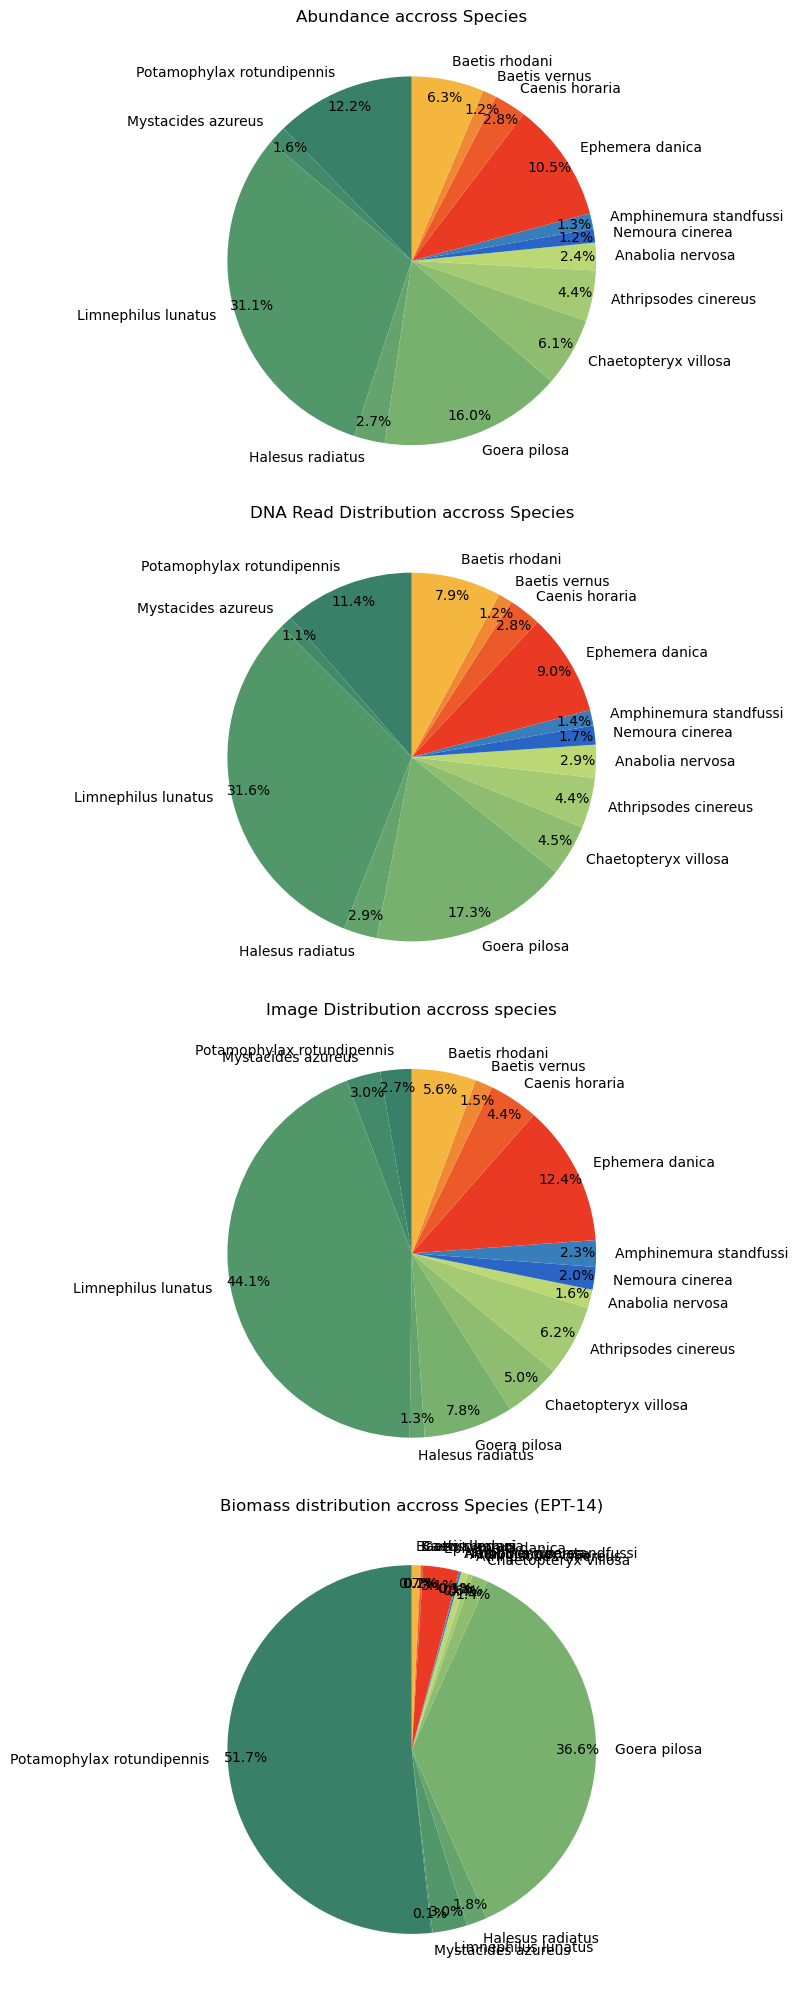

In [13]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

EPT_order = ['Baetis rhodani', 'Baetis vernus', 'Caenis horaria', 'Ephemera danica',
             'Amphinemura standfussi', 'Nemoura cinerea',
             'Anabolia nervosa', 'Athripsodes cinereus', 'Chaetopteryx villosa', 'Goera pilosa', 'Halesus radiatus', 'Limnephilus lunatus', 'Mystacides azureus', 'Potamophylax rotundipennis']

E_col = ['#F4B63F', '#EF8733', '#EC5A29', '#EA3A24']
P_col = ['#377EBA', '#2A64C5']
T_col = ['#BBD875', '#A4CB73', '#8EBD70', '#78B16E', '#64A46C', '#52976A', '#428A69', '#398068']

inner_colors = []
inner_colors.extend(E_col)
inner_colors.extend(P_col)
inner_colors.extend(T_col)

fig = plt.figure(figsize=(20, 20))

## First Plot
ax1 = plt.subplot2grid((4,1),(0,0))

df_abun = pd.DataFrame(EPT_14_clean_df.groupby('Specimen ID').first().groupby('Species_DNA').count())
df_abun = df_abun.reindex(EPT_order)

plt.pie(
    df_abun['read count_DNA'][::-1],
    labels=df_DNA.index[::-1],
    colors=inner_colors[::-1],
    autopct="%1.1f%%",
    pctdistance=0.9,
    startangle=90
)
plt.title('Abundance accross Species')

## Second Plot
ax1 = plt.subplot2grid((4,1),(1,0))

df_DNA = pd.DataFrame(EPT_14_clean_df.groupby('Specimen ID').first().groupby('Species_DNA')['read count_DNA'].sum())
df_DNA = df_DNA.reindex(EPT_order)

plt.pie(
    df_DNA['read count_DNA'][::-1],
    labels=df_DNA.index[::-1],
    colors=inner_colors[::-1],
    autopct="%1.1f%%",
    pctdistance=0.9,
    startangle=90
)
plt.title('DNA Read Distribution accross Species')

## Third Plot
ax1 = plt.subplot2grid((4,1),(2,0))

df_IMG = pd.DataFrame(EPT_14_clean_df.groupby('Species_DNA').count())
df_IMG = df_IMG.reindex(EPT_order)

plt.pie(
    df_IMG['read count_DNA'][::-1],
    labels=df_IMG.index[::-1],
    colors=inner_colors[::-1],
    autopct="%1.1f%%",
    pctdistance=0.9,
    startangle=90
)
plt.title('Image Distribution accross species')

## Fourth Plot
ax1 = plt.subplot2grid((4,1),(3,0))

df_biomass = pd.DataFrame(EPT_14_clean_df.groupby('Specimen ID').first().groupby('Species_DNA')['Specimen Weight'].sum())
df_biomass = df_biomass.reindex(EPT_order)

plt.pie(
    df_biomass['Specimen Weight'][::-1],
    labels=df_biomass.index[::-1],
    colors=inner_colors[::-1],
    autopct="%1.1f%%",
    pctdistance=0.9,
    startangle=90
)
plt.title('Biomass distribution accross Species (EPT-14)')
plt.tight_layout()
plt.show()

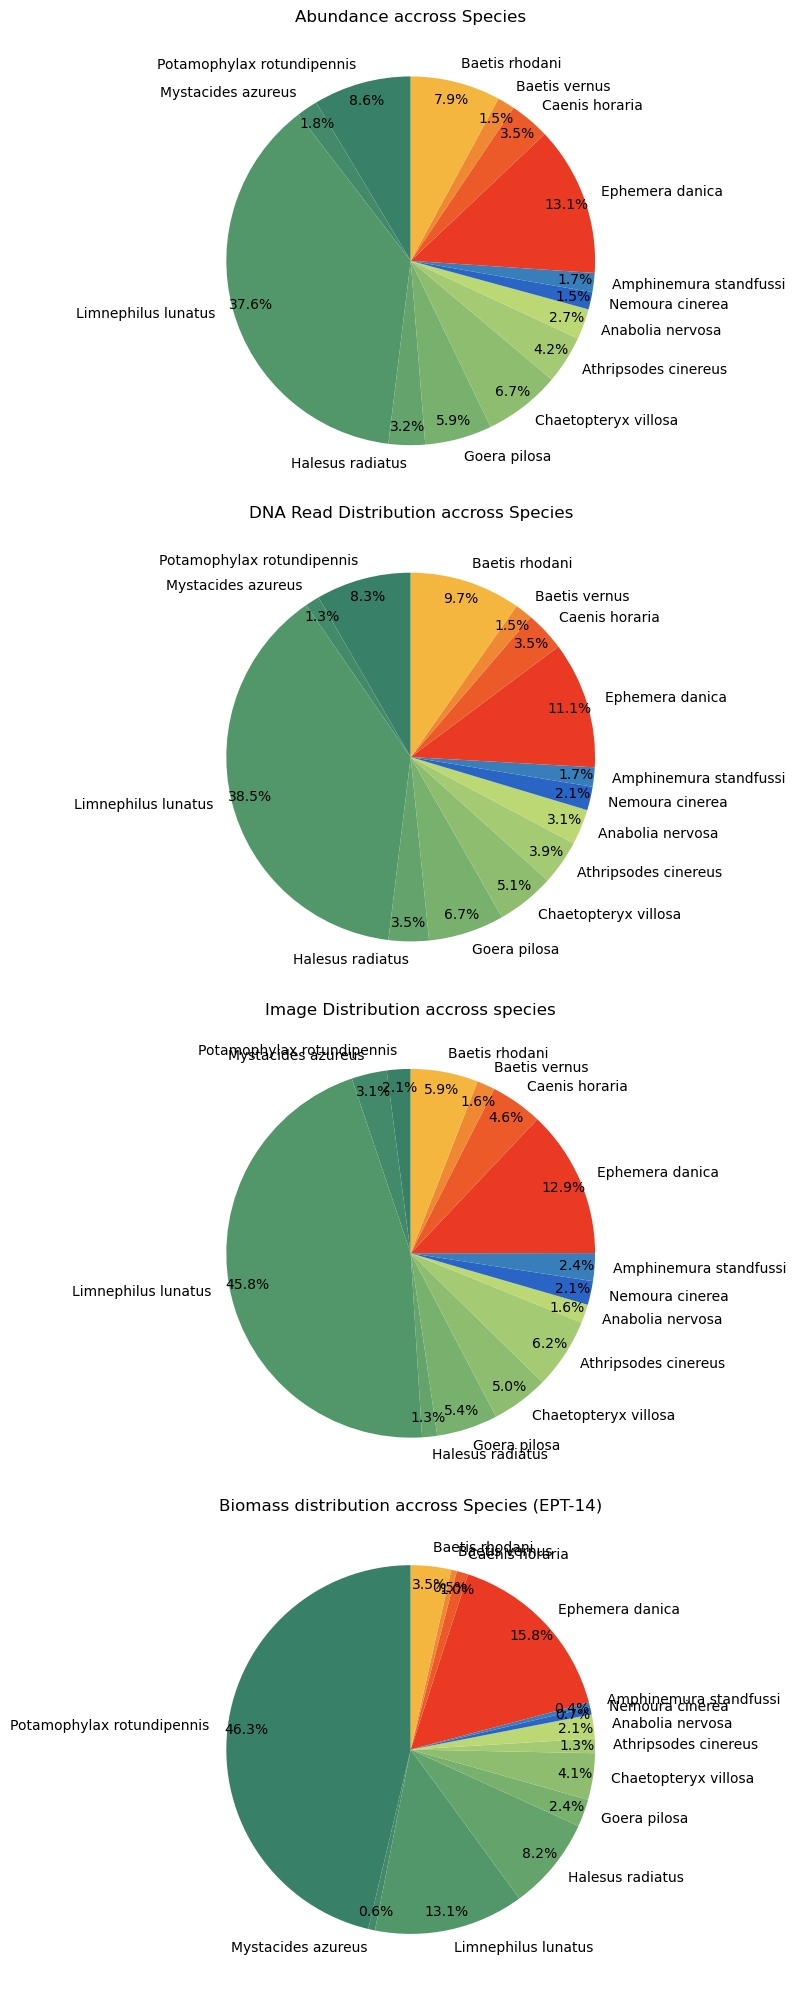

In [14]:
# Comparing biomass without Trichoptera with shells
mask = (~EPT_14_clean_df['Type'].str.contains('T_with_')  # Exclude types with 'T_with_' substring
    & (EPT_14_clean_df['Type'] != 'T_with')) # Exclude exact match 'T_with'

EPT_14_T_without = EPT_14_clean_df[mask]

fig = plt.figure(figsize=(20, 20))

## First Plot
ax1 = plt.subplot2grid((4,1),(0,0))

df_abun = pd.DataFrame(EPT_14_T_without.groupby('Specimen ID').first().groupby('Species_DNA').count())
df_abun = df_abun.reindex(EPT_order)

plt.pie(
    df_abun['read count_DNA'][::-1], # any column could be used here
    labels=df_DNA.index[::-1],
    colors=inner_colors[::-1],
    autopct="%1.1f%%",
    pctdistance=0.9,
    startangle=90
)
plt.title('Abundance accross Species')

## Second Plot
ax1 = plt.subplot2grid((4,1),(1,0))

df_DNA = pd.DataFrame(EPT_14_T_without.groupby('Specimen ID').first().groupby('Species_DNA')['read count_DNA'].sum())
df_DNA = df_DNA.reindex(EPT_order)

plt.pie(
    df_DNA['read count_DNA'][::-1],
    labels=df_DNA.index[::-1],
    colors=inner_colors[::-1],
    autopct="%1.1f%%",
    pctdistance=0.9,
    startangle=90
)
plt.title('DNA Read Distribution accross Species')

## Third Plot
ax1 = plt.subplot2grid((4,1),(2,0))

df_IMG = pd.DataFrame(EPT_14_T_without.groupby('Species_DNA').count())
df_IMG = df_IMG.reindex(EPT_order)

plt.pie(
    df_IMG['read count_DNA'][::-1],  # any column could be used here
    labels=df_IMG.index[::-1], 
    colors=inner_colors[::-1],
    autopct="%1.1f%%",
    pctdistance=0.9,
    startangle=90
)
plt.title('Image Distribution accross species')

## Fourth Plot
ax1 = plt.subplot2grid((4,1),(3,0))

df_biomass = pd.DataFrame(EPT_14_T_without.groupby('Specimen ID').first().groupby('Species_DNA')['Specimen Weight'].sum())
df_biomass = df_biomass.reindex(EPT_order)

plt.pie(
    df_biomass['Specimen Weight'][::-1],
    labels=df_biomass.index[::-1],
    colors=inner_colors[::-1],
    autopct="%1.1f%%",
    pctdistance=0.9,
    startangle=90
)
plt.title('Biomass distribution accross Species (EPT-14)')
plt.tight_layout()
plt.show()

/var/folders/b0/68bb2dkj42g1jr38kdd8m6pc0000gp/T/ipykernel_4745/1625377804.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=EPT_14_clean_df_short, y='read count_DNA', x='Species_DNA', order=EPT_order, palette=inner_colors, ax=axs[0])#
/var/folders/b0/68bb2dkj42g1jr38kdd8m6pc0000gp/T/ipykernel_4745/1625377804.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=EPT_14_clean_df_short, y='Image Count', x='Species_DNA', order=EPT_order, palette=inner_colors, ax=axs[1])
/var/folders/b0/68bb2dkj42g1jr38kdd8m6pc0000gp/T/ipykernel_4745/1625377804.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `

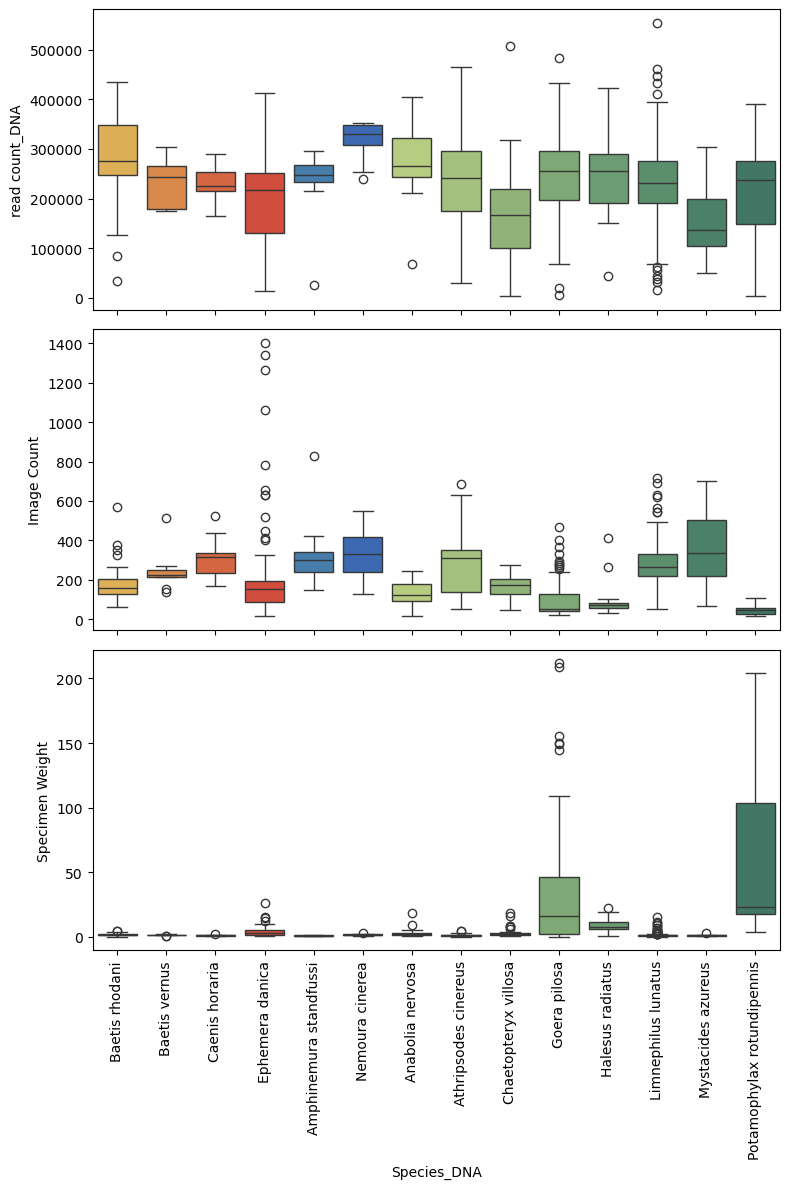

/var/folders/b0/68bb2dkj42g1jr38kdd8m6pc0000gp/T/ipykernel_4745/1625377804.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=EPT_14_T_without_short, y='read count_DNA', x='Species_DNA', order=EPT_order, palette=inner_colors, ax=axs[0])#
/var/folders/b0/68bb2dkj42g1jr38kdd8m6pc0000gp/T/ipykernel_4745/1625377804.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=EPT_14_T_without_short, y='Image Count', x='Species_DNA', order=EPT_order, palette=inner_colors, ax=axs[1])
/var/folders/b0/68bb2dkj42g1jr38kdd8m6pc0000gp/T/ipykernel_4745/1625377804.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable t

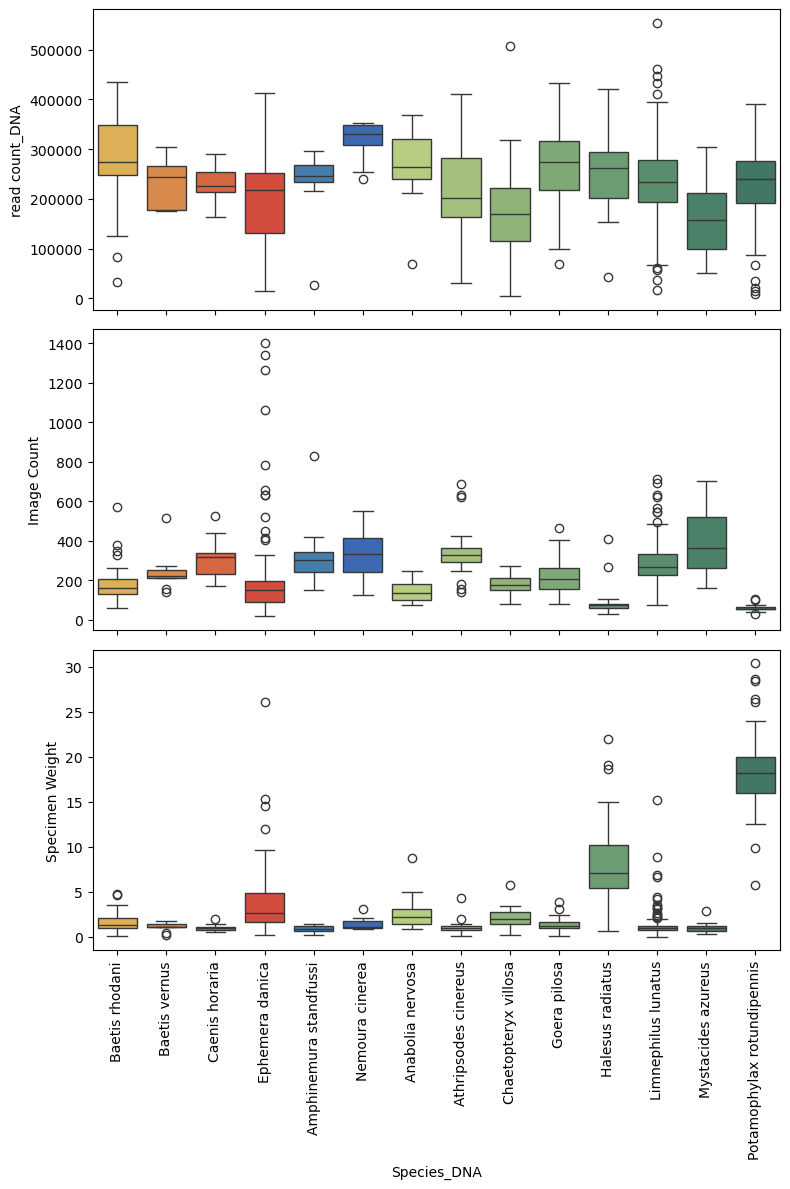

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# create a figure with 3 subplots
fig, axs = plt.subplots(3, 1, figsize=(8, 12))

# create the box plots
sns.boxplot(data=EPT_14_clean_df_short, y='read count_DNA', x='Species_DNA', order=EPT_order, palette=inner_colors, ax=axs[0])#
axs[0].set_xlabel('')
axs[0].set_xticklabels('')
sns.boxplot(data=EPT_14_clean_df_short, y='Image Count', x='Species_DNA', order=EPT_order, palette=inner_colors, ax=axs[1])
axs[1].set_xticklabels('')
axs[1].set_xlabel('')
sns.boxplot(data=EPT_14_clean_df_short, y='Specimen Weight', x='Species_DNA', order=EPT_order, palette=inner_colors, ax=axs[2])
plt.setp(axs[2].get_xticklabels(), rotation=90)

# show the plot
plt.tight_layout()
plt.show()

# Comparing biomass without Trichoptera with shells
mask = (~EPT_14_clean_df_short['Type'].str.contains('T_with_')  # Exclude types with 'T_with_' substring
    & (EPT_14_clean_df_short['Type'] != 'T_with')) # Exclude exact match 'T_with'

EPT_14_T_without_short = EPT_14_clean_df_short[mask]

# create a figure with 3 subplots
fig, axs = plt.subplots(3, 1, figsize=(8, 12))

# create the box plots
sns.boxplot(data=EPT_14_T_without_short, y='read count_DNA', x='Species_DNA', order=EPT_order, palette=inner_colors, ax=axs[0])#
axs[0].set_xlabel('')
axs[0].set_xticklabels('')
sns.boxplot(data=EPT_14_T_without_short, y='Image Count', x='Species_DNA', order=EPT_order, palette=inner_colors, ax=axs[1])
axs[1].set_xticklabels('')
axs[1].set_xlabel('')
sns.boxplot(data=EPT_14_T_without_short, y='Specimen Weight', x='Species_DNA', order=EPT_order, palette=inner_colors, ax=axs[2])
plt.setp(axs[2].get_xticklabels(), rotation=90)

# show the plot
plt.tight_layout()
plt.show()


In [16]:
s_cor_df_dict = {}
s_cor_df_dict['Abundance'] = df_abun['read count_DNA']
s_cor_df_dict['Read Count'] = df_DNA['read count_DNA']
s_cor_df_dict['Image Count'] = df_IMG['read count_DNA']
s_cor_df_dict['Biomass'] = df_biomass['Specimen Weight']

pd.DataFrame(s_cor_df_dict)

,Abundance,Read Count,Image Count,Biomass
Species_DNA,,,,
Baetis rhodani,47,13367652.0,8257,71.94
Baetis vernus,9,2109765.0,2211,9.94
Caenis horaria,21,4815871.0,6375,20.57
Ephemera danica,78,15248136.0,18093,322.18
Amphinemura standfussi,10,2322389.0,3405,8.51
Nemoura cinerea,9,2837258.0,2911,13.27
Anabolia nervosa,16,4267521.0,2295,42.69
Athripsodes cinereus,25,5370756.0,8651,25.90
Chaetopteryx villosa,40,6983425.0,7011,82.82


In [17]:
import numpy as np
import scipy.stats

def calc_cor_metrics(Column_A, Column_B):
    cor_df_dict = {}
    cor_df_dict[f'{Column_A} <=> {Column_B}: All EPTs'] = [scipy.stats.pearsonr(EPT_14_clean_df_short[Column_A], EPT_14_clean_df_short[Column_B]), # Pearson's r
                                                 scipy.stats.spearmanr(EPT_14_clean_df_short[Column_A], EPT_14_clean_df_short[Column_B]), # Spearman's rho
                                                 scipy.stats.kendalltau(EPT_14_clean_df_short[Column_A], EPT_14_clean_df_short[Column_B]), # Kendall's tau
                                                 ]
    cor_df_dict[f'{Column_A} <=> {Column_B}: EPTs without shell'] = [scipy.stats.pearsonr(EPT_14_T_without_short[Column_A], EPT_14_T_without_short[Column_B]), # Pearson's r
                                                 scipy.stats.spearmanr(EPT_14_T_without_short[Column_A], EPT_14_T_without_short[Column_B]), # Spearman's rho
                                                 scipy.stats.kendalltau(EPT_14_T_without_short[Column_A], EPT_14_T_without_short[Column_B]), # Kendall's tau
                                                 ]
    return cor_df_dict

In [18]:
scipy.stats.normaltest(EPT_14_clean_df_short['Specimen Weight'])

NormaltestResult(statistic=540.3403845147184, pvalue=4.640623424485691e-118)

In [19]:
scipy.stats.normaltest(EPT_14_clean_df_short['Log_weights'])

NormaltestResult(statistic=41.76273214874039, pvalue=8.537641985554411e-10)

In [20]:
scipy.stats.normaltest(EPT_14_clean_df_short['read count_DNA'])

NormaltestResult(statistic=11.772384289744087, pvalue=0.0027775330290555167)

In [21]:
pd.DataFrame(calc_cor_metrics('read count_DNA', 'Specimen Weight'))

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


,read count_DNA <=> Specimen Weight: All EPTs,read count_DNA <=> Specimen Weight: EPTs without shell
0,"(-0.05231861728961179, 0.1542505997895193)","(-0.04490792963015966, 0.27409955215210907)"
1,"(-0.092824106899143, 0.011360524131289577)","(-0.11178237825549192, 0.0063432298982691645)"
2,"(-0.06227447152310975, 0.011138984990792772)","(-0.07516378314541033, 0.006164124898431809)"


In [22]:
pd.DataFrame(calc_cor_metrics('read count_DNA', 'Log_weights'))

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


,read count_DNA <=> Log_weights: All EPTs,read count_DNA <=> Log_weights: EPTs without shell
0,"(-0.09288087360184548, 0.011310257865934979)","(-0.11541572825148284, 0.004820396031564935)"
1,"(-0.092824106899143, 0.011360524131289577)","(-0.11178237825549192, 0.0063432298982691645)"
2,"(-0.06227447152310975, 0.011138984990792772)","(-0.07516378314541033, 0.006164124898431809)"


In [23]:
pd.DataFrame(calc_cor_metrics('read count_DNA', 'Log+1_weights'))

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


,read count_DNA <=> Log+1_weights: All EPTs,read count_DNA <=> Log+1_weights: EPTs without shell
0,"(-0.07129504603975367, 0.05206901629501333)","(-0.0834940643769392, 0.04175916233307196)"
1,"(-0.092824106899143, 0.011360524131289577)","(-0.11178237825549192, 0.0063432298982691645)"
2,"(-0.06227447152310975, 0.011138984990792772)","(-0.07516378314541033, 0.006164124898431809)"


In [24]:
pd.DataFrame(calc_cor_metrics('read count_DNA', 'Image Count'))

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


,read count_DNA <=> Image Count: All EPTs,read count_DNA <=> Image Count: EPTs without shell
0,"(0.010400040649329902, 0.7771653840550384)","(-0.011252616240636492, 0.7841520294180938)"
1,"(0.025216813847343946, 0.49251611679938423)","(0.008412157147127413, 0.8377544108029976)"
2,"(0.015291247035397458, 0.5334749200347586)","(0.0045555671768116755, 0.868170546924206)"


In [38]:
EPT_14_clean_df_short['read count_DNA'].var()

7841260600.479663

In [39]:
EPT_14_clean_df_short['read count_DNA'].mean()

228952.6460296097

In [44]:
EPT_14_clean_df_short['Log_reads'] = np.log(EPT_14_clean_df_short['read count_DNA'])

Text(0.5, 1.0, 'Residuals')

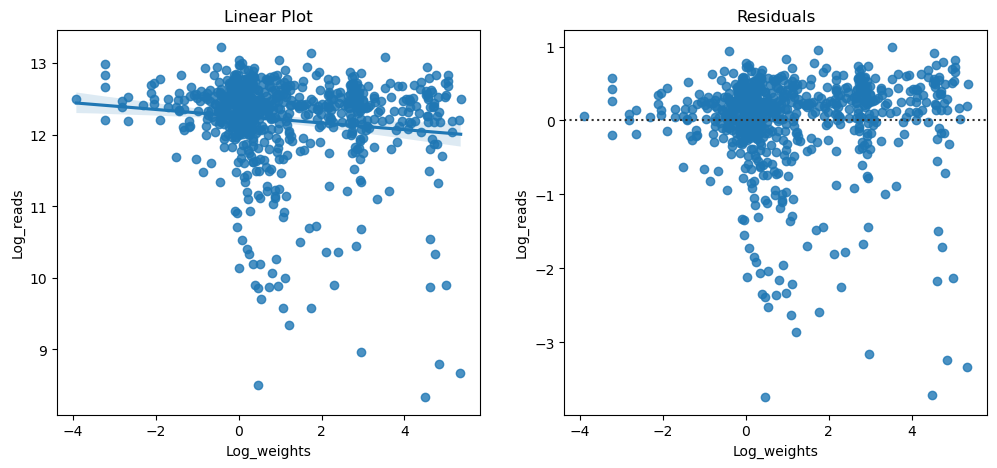

In [ ]:
import seaborn as sns
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.regplot(data=EPT_14_clean_df_short, x='Log_weights', y= 'Log_reads', ax=axs[0])
axs[0].set_title('Linear Plot')
sns.residplot(data=EPT_14_clean_df_short, x='Log_weights', y= 'Log_reads', ax=axs[1])
axs[1].set_title('Residuals')

Text(0.5, 1.0, 'Residuals')

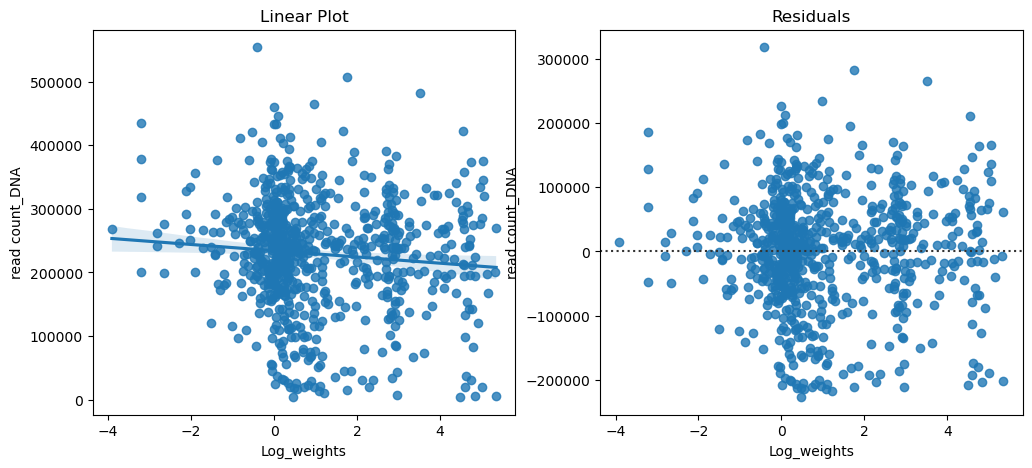

In [62]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.regplot(data=EPT_14_clean_df_short, x='Log_weights', y= 'read count_DNA', ax=axs[0])
axs[0].set_title('Linear Plot')
sns.residplot(data=EPT_14_clean_df_short, x='Log_weights', y= 'read count_DNA', ax=axs[1])
axs[1].set_title('Residuals')

Text(0.5, 1.0, 'Residuals')

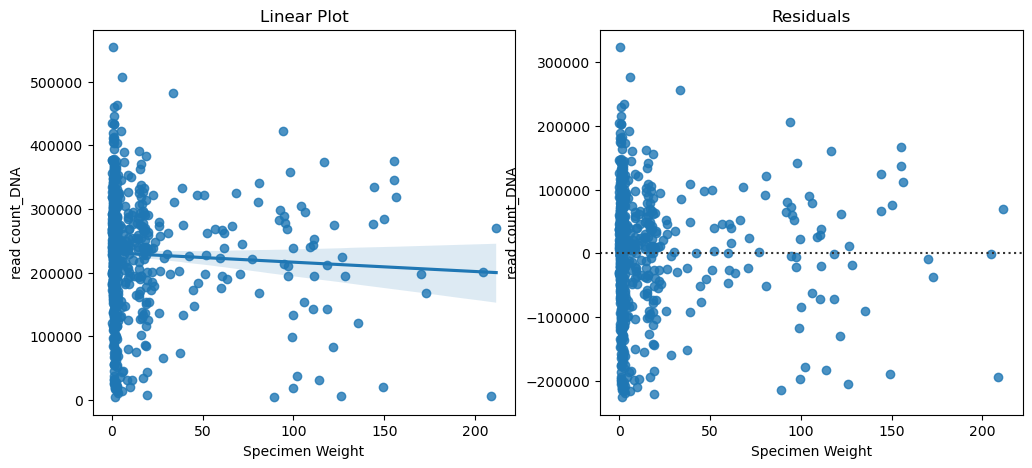

In [64]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.regplot(data=EPT_14_clean_df_short, x='Specimen Weight', y= 'read count_DNA', ax=axs[0])
axs[0].set_title('Linear Plot')
sns.residplot(data=EPT_14_clean_df_short, x='Specimen Weight', y= 'read count_DNA', ax=axs[1])
axs[1].set_title('Residuals')

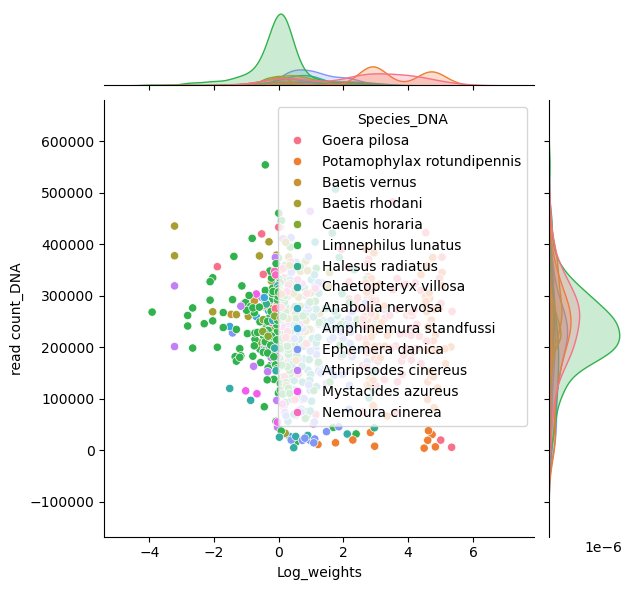

In [40]:
sns.jointplot(y=EPT_14_clean_df_short['read count_DNA'], x=EPT_14_clean_df_short['Log_weights'], hue=EPT_14_clean_df_short['Species_DNA'])

In [28]:
largest_area_per_group = EPT_14_clean_df.loc[EPT_14_clean_df.groupby("Species_DNA")["Area"].idxmax()]
image_file_names = largest_area_per_group["Image File Name"].tolist()
image_file_names

['1_1_B8_1_2023_12_04-16-08-07-272.PNG',
 '2_7_E10_1_2023_12_22-09-07-24-444.PNG',
 '1_1_F10_5_2023_12_05-15-00-08-090.PNG',
 '1_6_C12_1_2023_12_18-16-27-32-047.PNG',
 '1_6_C11_1_2023_12_18-16-26-20-323.PNG',
 '2_4_A5_2_2023_12_13-11-22-08-627.PNG',
 '1_8_A7_2_2023_12_22-12-47-54-304.PNG',
 '1_5_D7_1_2023_12_15-10-31-54-590.PNG',
 '1_9_A12_4_2024_01_09-11-56-30-588.PNG',
 '1_7_E8_3_2023_12_20-14-55-10-459.PNG',
 '1_7_E9_1_2023_12_20-14-59-50-920.PNG',
 '1_1_F3_1_2023_12_05-14-40-09-403.PNG',
 '2_8_B7_2_2023_12_22-14-31-48-566.PNG',
 '1_8_A10_9_2023_12_22-12-58-03-947.PNG']

In [29]:
# Group by "Species_DNA" and find the row with the largest "Area" in each group
largest_area_per_group = EPT_14_clean_df.loc[EPT_14_clean_df.groupby("Species_DNA")["Area"].idxmax()]
image_file_paths = [f"0_images/{row['Specimen ID']}/{row['Sample Name/Number']}/{row['Image File Name']}" for _, row in largest_area_per_group.iterrows()]
image_file_paths


['0_images/1_B8/1_B8_1/1_1_B8_1_2023_12_04-16-08-07-272.PNG',
 '0_images/7_E10/7_E10_1/2_7_E10_1_2023_12_22-09-07-24-444.PNG',
 '0_images/1_F10/1_F10_5/1_1_F10_5_2023_12_05-15-00-08-090.PNG',
 '0_images/6_C12/6_C12_1/1_6_C12_1_2023_12_18-16-27-32-047.PNG',
 '0_images/6_C11/6_C11_1/1_6_C11_1_2023_12_18-16-26-20-323.PNG',
 '0_images/4_A5/4_A5_2/2_4_A5_2_2023_12_13-11-22-08-627.PNG',
 '0_images/8_A7/8_A7_2/1_8_A7_2_2023_12_22-12-47-54-304.PNG',
 '0_images/5_D7/5_D7_1/1_5_D7_1_2023_12_15-10-31-54-590.PNG',
 '0_images/9_A12/9_A12_4/1_9_A12_4_2024_01_09-11-56-30-588.PNG',
 '0_images/7_E8/7_E8_3/1_7_E8_3_2023_12_20-14-55-10-459.PNG',
 '0_images/7_E9/7_E9_1/1_7_E9_1_2023_12_20-14-59-50-920.PNG',
 '0_images/1_F3/1_F3_1/1_1_F3_1_2023_12_05-14-40-09-403.PNG',
 '0_images/8_B7/8_B7_2/2_8_B7_2_2023_12_22-14-31-48-566.PNG',
 '0_images/8_A10/8_A10_9/1_8_A10_9_2023_12_22-12-58-03-947.PNG']